### Aprendizaje Automático II - Miguel Angel Ruiz Ortiz

## Notebook de entrenamiento

Implemente los siguientes clasificadores

1. un Perceptrón multicapa;
2. una Máquina de aprendizaje extremo;
3. una Máquina de aprendizaje con pesos binarios ${-1,1}$;

para clasificar datos que tienen la siguiente representación: $x_i$ una matriz de $n \times n$ enteros (con n=12), $y_i \in \{0,1,2,3,4,5\}$, donde las entradas de cada matriz se pueden interpretar como índices de columnas de otra matriz $E = d \times m$ (d=128, m=256).

### Librerías

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
devices = tf.config.list_physical_devices()
print("Devices: ", devices)

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    details = tf.config.experimental.get_device_details(gpus[0])
    print("GPU details: ", details)

Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


### Carga de datos

El script ``create_datasets.py`` divide los datos en un conjunto de entrenamiento, de validación y de prueba, y los guarda en archivos .npy. El output de dicho script describe los porcentajes de cada conjunto:

Total samples: 35000
- Training: 72.2%, 25287 samples
- Validation: 12.8%, 4463 samples
- Testing: 15.0%, 5250 samples

In [3]:
# training and validation datasets
X_train = np.load("X_train.npy").astype("float32")
X_train = X_train.reshape(X_train.shape[0], -1)

y_train = np.load("y_train.npy").astype("float32")

X_val = np.load("X_val.npy").astype("float32")
X_val = X_val.reshape(X_val.shape[0], -1)

y_val = np.load("y_val.npy").astype("float32")

In [4]:
# labels without one-hot
labels_train = np.argmax(y_train, axis=1)
labels_val = np.argmax(y_val, axis=1)

# label names
label_2_text = {
    0: "anger",
    1: "disgust",
    2: "fear",
    3: "happiness",
    4: "sadness",
    5: "surprise",
    6: "neutral",
}

Dado que los datos tienen enteros del 0 al 255 pero su magnitud no importa, entonces también haremos pruebas haciendo una normalización de los datos con ``sklearn.preprocessing.StandardScaler``.

In [5]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_val = scaler.transform(X_val)

## Distribución de etiquetas

En la Figura 1 se muestra el histograma de frecuencias de las etiquetas en el conjunto de entrenamiento, y se puede observar cómo la etiqueta *disgust* tiene pocos datos. En el conjunto de datos completo la frecuencia de las etiquetas es la siguiente:

- anger: 4813
- disgust: 537
- fear: 4993
- happiness: 8800
- sadness: 5920
- surprise: 3890
- neutral: 6047

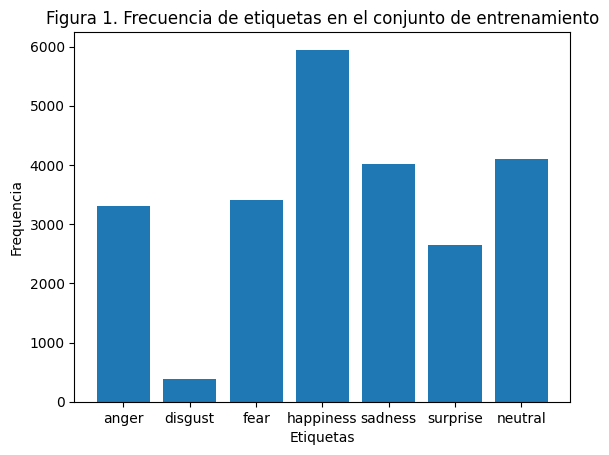

In [6]:
plt.bar(label_2_text.values(), np.sum(y_train, axis=0))
plt.xlabel("Etiquetas")
plt.ylabel("Frequencia")
plt.title("Figura 1. Frecuencia de etiquetas en el conjunto de entrenamiento")
plt.show()

## Funciones útiles

Función que evalua el modelo dado (model) en los datos de entrenamiento (X_train) y datos de validación dados (X_val). Imprime la precisión, recall y matriz de confusión en cada dataset

In [7]:
def print_model_info(model, X_train, X_val):
    # predictions - argmax to retrieve label with highest probability
    y_pred_train = tf.argmax(model.predict(X_train), axis=1)
    y_pred_val = tf.argmax(model.predict(X_val), axis=1)

    print("Precisión en datos de entrenamiento:", accuracy_score(labels_train, y_pred_train))
    print("Precisión en datos de validación:", accuracy_score(labels_val, y_pred_val))
    print("Recall en datos de entrenamiento:", recall_score(labels_train, y_pred_train, average="macro"))
    print("Recall en datos de validación:", recall_score(labels_val, y_pred_val, average="macro"))
    print("\nMatriz de confusión en datos de entrenamiento:")
    print(confusion_matrix(labels_train, y_pred_train))
    print("\nMatriz de confusión en datos de validación:")
    print(confusion_matrix(labels_val, y_pred_val))
    

## Perceptrón Multicapa

Para el modelo, suponemos que los datos están *aplanados* para evitar agregar la capa ``keras.layers.Flatten``. Esto debido a que haremos el preprocesamiento de normalización usando ``StandardScaler`` supone que los datos están aplanados.

In [8]:
def get_mlp_model(shape_input = 144):
    return keras.models.Sequential(
        [
            keras.layers.Input(shape=(shape_input, )),
            keras.layers.Dense(3000, activation="relu"),
            keras.layers.Dense(1500, activation="relu"),
            keras.layers.Dense(250, activation="relu"),
            keras.layers.Dense(7, activation="softmax"),
        ]
    )

### Datos en crudo

Primero usamos los datos en crudo. Guardaremos los dos mejores modelos encontrados durante el entrenamiento de acuerdo a la función de error en el conjunto de entrenamiento y en validación.

In [9]:
mlp_model = get_mlp_model()

mlp_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

mlp_history = mlp_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=15
)

Epoch 1/15


2024-09-05 22:33:18.617978: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-09-05 22:33:18.617997: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-05 22:33:18.618008: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-05 22:33:18.618024: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-05 22:33:18.618036: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-09-05 22:33:19.013473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


744/744 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.1948 - loss: 20.4752 - val_accuracy: 0.2150 - val_loss: 1.8523
Epoch 2/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.2244 - loss: 1.8512 - val_accuracy: 0.2571 - val_loss: 1.8220
Epoch 3/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.2428 - loss: 1.8359 - val_accuracy: 0.2605 - val_loss: 1.8067
Epoch 4/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.2425 - loss: 1.8262 - val_accuracy: 0.2605 - val_loss: 1.8368
Epoch 5/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.2517 - loss: 1.8309 - val_accuracy: 0.2605 - val_loss: 1.8095
Epoch 6/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.2499 - loss: 1.8170 - val_accuracy: 0.2605 - val_loss: 1.8048
Epoch 7/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.2478 - loss: 1.8138 - val_accuracy: 0.2605 - val_loss: 1.8034
Epoch 8/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.2499 - loss: 1.8122 - val_accura

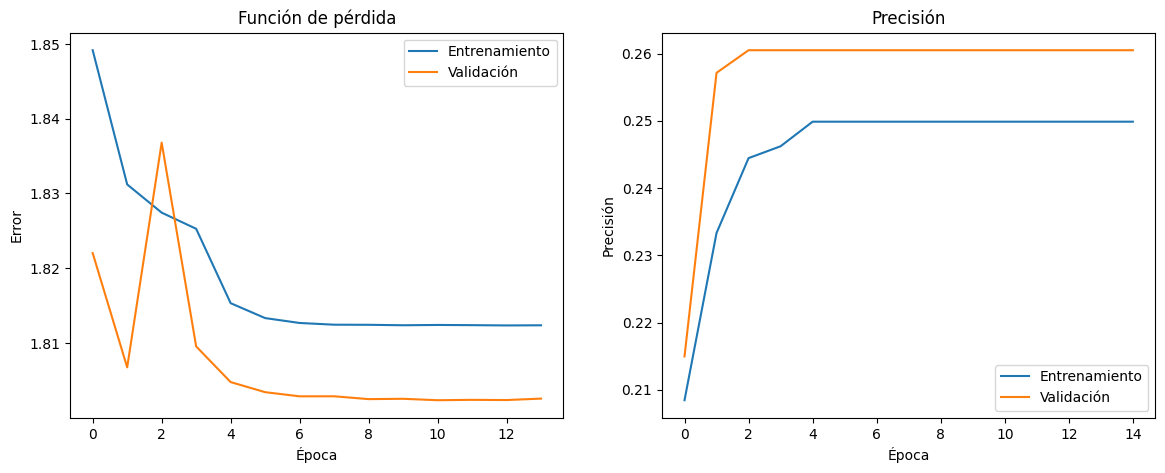

In [10]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(mlp_history.history["loss"][1:], label="Entrenamiento")
plt.plot(mlp_history.history["val_loss"][1:], label="Validación")
plt.title("Función de pérdida")
plt.xlabel("Época")
plt.ylabel("Error")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mlp_history.history["accuracy"], label="Entrenamiento")
plt.plot(mlp_history.history["val_accuracy"], label="Validación")
plt.title("Precisión")
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.legend()

plt.show()

In [11]:
print_model_info(mlp_model, X_train, X_val)

744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Precisión en datos de entrenamiento: 0.24987394957983194
Precisión en datos de validación: 0.2605042016806723
Recall en datos de entrenamiento: 0.14285714285714285
Recall en datos de validación: 0.14285714285714285

Matriz de confusión en datos de entrenamiento:
[[   0    0    0 3303    0    0    0]
 [   0    0    0  377    0    0    0]
 [   0    0    0 3409    0    0    0]
 [   0    0    0 5947    0    0    0]
 [   0    0    0 4011    0    0    0]
 [   0    0    0 2652    0    0    0]
 [   0    0    0 4101    0    0    0]]

Matriz de confusión en datos de validación:
[[   0    0    0  819    0    0    0]
 [   0    0    0   81    0    0    0]
 [   0    0    0  831    0    0    0]
 [   0    0    0 1550    0    0    0]
 [   0    0    0  972    0    0    0]
 [   0    0    0  669    0    0    0]
 [   0    0    0 1028    0    0    0]]


### Datos normalizados

In [12]:
mlp_model = get_mlp_model()

mlp_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

mlp_history = mlp_model.fit(
    X_scaled_train,
    y_train,
    validation_data=(X_scaled_val, y_val),
    epochs=15,
)

Epoch 1/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.2271 - loss: 1.8425 - val_accuracy: 0.2620 - val_loss: 1.7944
Epoch 2/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.2522 - loss: 1.7887 - val_accuracy: 0.2612 - val_loss: 1.7941
Epoch 3/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.2811 - loss: 1.7428 - val_accuracy: 0.2612 - val_loss: 1.8013
Epoch 4/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.3184 - loss: 1.6558 - val_accuracy: 0.2566 - val_loss: 1.8249
Epoch 5/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.3970 - loss: 1.5006 - val_accuracy: 0.2385 - val_loss: 1.9353
Epoch 6/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.5110 - loss: 1.2476 - val_accuracy: 0.2471 - val_loss: 2.1168
Epoch 7/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.6575 - loss: 0.9213 - val_accuracy: 0.2425 - val_loss: 2.3970
Epoch 8/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.7794 - loss: 0.6180 - 

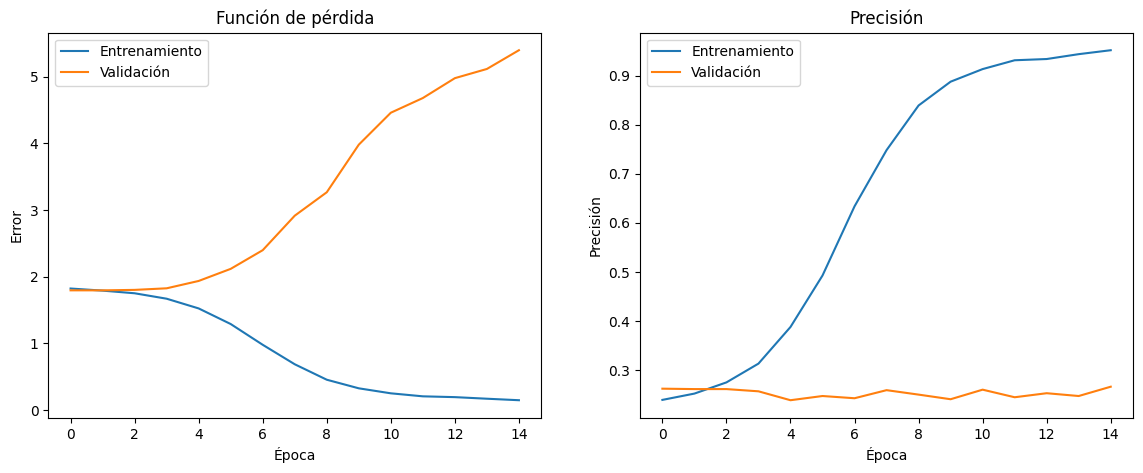

In [13]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(mlp_history.history["loss"], label="Entrenamiento")
plt.plot(mlp_history.history["val_loss"], label="Validación")
plt.title("Función de pérdida")
plt.xlabel("Época")
plt.ylabel("Error")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mlp_history.history["accuracy"], label="Entrenamiento")
plt.plot(mlp_history.history["val_accuracy"], label="Validación")
plt.title("Precisión")
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.legend()

plt.show()

In [14]:
print_model_info(mlp_model, X_scaled_train, X_scaled_val)

744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Precisión en datos de entrenamiento: 0.9665126050420169
Precisión en datos de validación: 0.26605042016806724
Recall en datos de entrenamiento: 0.9640258777385846
Recall en datos de validación: 0.24561827095674585

Matriz de confusión en datos de entrenamiento:
[[3182    0   11   38   35    5   32]
 [   2  359    1    5    5    3    2]
 [  39    2 3218   71   44   25   10]
 [  35    0   11 5824   42    8   27]
 [  12    0   11   52 3904   14   18]
 [  11    0    5   11   10 2605   10]
 [  26    1   14   65   75    9 3911]]

Matriz de confusión en datos de validación:
[[148   2  65 271 161  70 102]
 [ 10  15   5  26   8   8   9]
 [100   2 144 243 161  71 110]
 [178   4 133 597 297 123 218]
 [134   0  66 317 248  68 139]
 [ 67   2  62 163  79 231  65]
 [134   2  84 325 196  87 200]]


Dado que obtuvimos un mejor rendimiento con los datos escalados, vamos a trabajar en todos los modelos con estos datos. 

**Nota:** Este comportamiento también se observó en las máquinas de aprendizaje extremo, pero al final decidí sólo mostrar los resultados con los datos escalados.

In [15]:
mlp_model.save("mlp_model.keras")

## Extreme Learning Machine

En la siguiente clase se implementa una máquina de aprendizaje extremo con los siguientes parámetros:
- ``shape_intput``: Tamaño del input.
- ``n_neurons``: Nûmero de neuronas en la capa oculta.
- ``n_classes``: Número de clases del dataset, i.e., número de neuronas de la capa de salida.
- ``regularizer``: String que define el regularizador a usarse en el problema de mínimos cuadrados (ninguno, Ridge, Lasso, Elastic-Net). Por defecto es ``None`` que significa que no se añade un regularizador, y las posibles opciones son "ridge", "lasso" y "elastic-net".
- ``activation``: Función de activación que se usará en la capa oculta, por defecto ``keras.activations.sigmoid``. 
- ``binary_weights``: Booleano para especificar si la capa oculta va a tener pesos binarios (-1 o 1) o pesos flotantes (aleatorios ambos). Por defecto es ``False``.
- ``alpha``: Factor para el término de regularización $||\beta ||_p^p$, $p=1$ (Lasso) ó $p=2$ (Ridge), donde $\beta$ son los pesos de la capa de salida. Por defecto ``alpha = 1.0``.
- ``l1_ratio``: Factor $\rho \in (0,1)$ para el término de regularización $\alpha \rho ||\beta||_1 + (\alpha(1-\rho)/2)||\beta||_2^2$, donde $\beta$ son los pesos de la capa de salida, que se utiliza para la regularización Elastic-Net.

El problema de mínimos cuadrados se resuelve con Scikit-Learn en todos los casos. Cuando no hay regularizador, la solución $\beta$ se puede encontrar en términos de la pseudoinversa de la matriz $H=g(XW + b)$, donde $g$ es la función de activación, $X$ son los datos, $W$ es la matriz de pesos de la capa escondida, y $b$ el vector de sesgo. Sin embargo, esto puede ser numéricamente estable como se muestra mâs adelante.

In [16]:
class ExtremeLearningMachine:
    def __init__(
        self,
        shape_input,
        n_neurons,
        n_classes,
        regularizer=None,
        activation=keras.activations.sigmoid,
        binary_weights=False,
        alpha=1.0,
        l1_ratio=0.5,
    ):
        self.regularizer = regularizer
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.activation = activation

        # we define forward pipeline for eml with keras, but we are not going to train the model
        self.eml_model = keras.models.Sequential(
            [
                keras.layers.Input(shape=shape_input),
                keras.layers.Dense(
                    n_neurons,
                    activation=activation,
                    bias_initializer=tf.keras.initializers.LecunNormal(),  # bias initializer by default is zero, so we change to non-zero random bias
                ),
                keras.layers.Dense(n_classes, use_bias=False),
            ]
        )

        # if binary weights for layer is needed, we change weights of hidden layer
        if binary_weights:
            # binary weights 0, 1
            W = np.random.binomial(n=1, p=0.5, size=(shape_input[0], n_neurons))
            b = np.random.binomial(n=1, p=0.5, size=(n_neurons, ))

            # change binary weights to -1, 1
            W = 2.0 * W - 1
            b = 2.0 * b - 1

            self.eml_model.layers[0].set_weights([W, b])

    def fit(self, X, y):
        # solve linear problem ||y - H*beta||^2_2 + regularizer
        # we use scikit-learn for numerical stability, because pseudoinverse could be numerically unstable
        if self.regularizer == "ridge":
            least_squares = linear_model.Ridge(alpha=self.alpha, fit_intercept=False)
        elif self.regularizer == "lasso":
            least_squares = linear_model.Lasso(alpha=self.alpha, fit_intercept=False)
        elif self.regularizer == "elastic-net":
            least_squares = linear_model.ElasticNet(alpha=self.alpha, l1_ratio=self.l1_ratio, fit_intercept=False)
        else:
            least_squares = linear_model.LinearRegression(fit_intercept=False)

        W, b = self.eml_model.layers[0].get_weights()  # weight matrix and bias vector for hidden layer
        H = self.activation(X @ W + b)

        least_squares.fit(H, y)
        self.eml_model.layers[-1].set_weights([least_squares.coef_.T])  # set beta weight matrix for last layer solving least squares

    def predict(self, X):
        return tf.nn.softmax(self.eml_model(X))
    
    def save(self, filepath):
        self.eml_model.save(filepath)

### Sin regularización

In [17]:
eml_simple = ExtremeLearningMachine(shape_input=(144, ), n_neurons=2000, n_classes=7)

eml_simple.fit(X_scaled_train, y_train)
print_model_info(eml_simple, X_scaled_train, X_scaled_val)
eml_simple.save("eml_simple.keras")

Precisión en datos de entrenamiento: 0.39046218487394957
Precisión en datos de validación: 0.22218487394957984
Recall en datos de entrenamiento: 0.3181230994918591
Recall en datos de validación: 0.16675115138202265

Matriz de confusión en datos de entrenamiento:
[[ 839    0  319 1168  435  145  397]
 [  28   15   40  138   64   22   70]
 [ 218    0 1015 1145  454  155  422]
 [ 330    0  383 3781  614  228  611]
 [ 271    0  282 1332 1480  157  489]
 [ 157    0  197  893  324  774  307]
 [ 293    0  293 1424  507  195 1389]]

Matriz de confusión en datos de validación:
[[ 89   0  82 319 148  42 139]
 [  9   0   9  35   9   2  17]
 [ 87   0 115 332 128  49 120]
 [139   0 168 684 249  88 222]
 [ 95   0 103 393 174  49 158]
 [ 49   0  76 267  89  90  98]
 [ 83   0 113 424 180  58 170]]


Con estos mismos datos y la misma red, vamos a encontrar los pesos $\beta$ de la última capa utilizando la pseudoinversa de $H$ para ilustrar que en efecto puede esto ser numéricamente inestable. Se observa que $||H\beta - T||$ es menor utilizando Scikit-Learn.

**UPDATE:** Cuando cambié a los datos normalizados, el error ya era el mismo. Con los datos en crudo la diferencia sí era bastante, pero igual dejo el código para ilustrar que son equivalentes los métodos.

In [18]:
W, b = eml_simple.eml_model.layers[0].get_weights() # weight matrix and bias vector for first layer
H = tf.nn.sigmoid(X_scaled_train@W + b)
beta_1 = np.linalg.pinv(H)@y_train # weights of last layer using pseudoinverse of H
beta = eml_simple.eml_model.layers[-1].get_weights()[0] # weights of last layer found with scikit-learn when called fit method
print("Error usando pseudoinversa: ||H*Beta - T|| =", np.linalg.norm(H@beta_1 - y_train))
print("Error usando Scikit-Learn: ||H*Beta - T|| =", np.linalg.norm(H@beta - y_train))

Error usando pseudoinversa: ||H*Beta - T|| = 133.24756
Error usando Scikit-Learn: ||H*Beta - T|| = 133.25105


### Regularización Ridge

In [19]:
eml_ridge = ExtremeLearningMachine(
    shape_input=(144,), n_neurons=2000, n_classes=7, regularizer="ridge"
)

eml_ridge.fit(X_scaled_train, y_train)
print_model_info(eml_ridge, X_scaled_train, X_scaled_val)
eml_simple.save("eml_ridge.keras")

Precisión en datos de entrenamiento: 0.28352941176470586
Precisión en datos de validación: 0.2526050420168067
Recall en datos de entrenamiento: 0.18676162941196717
Recall en datos de validación: 0.15503651735759896

Matriz de confusión en datos de entrenamiento:
[[ 110    0   67 2535  292   64  235]
 [   4    0   12  293   33   11   24]
 [  45    0  145 2634  267  107  211]
 [  52    0   76 5117  326   94  282]
 [  51    0   71 2960  577   67  285]
 [  33    0   64 1951  171  243  190]
 [  39    0   71 3033  308   94  556]]

Matriz de confusión en datos de validación:
[[  18    0   10  639   61   22   69]
 [   0    0    0   69    2    1    9]
 [   9    0   21  663   62   20   56]
 [  19    0   30 1254  116   26  105]
 [  18    0   19  731   96   14   94]
 [   4    0   20  506   57   37   45]
 [  13    0   20  810   86   22   77]]


### Regularización Lasso

In [40]:
eml_lasso = ExtremeLearningMachine(
    shape_input=(144, ), n_neurons=2000, n_classes=7, regularizer="lasso", alpha=0.1
)
eml_lasso.fit(X_scaled_train, y_train)

print_model_info(eml_lasso, X_scaled_train, X_scaled_val)
eml_lasso.save("eml_lasso.keras")

Precisión en datos de entrenamiento: 0.24987394957983194
Precisión en datos de validación: 0.2605042016806723
Recall en datos de entrenamiento: 0.14285714285714285
Recall en datos de validación: 0.14285714285714285

Matriz de confusión en datos de entrenamiento:
[[   0    0    0 3303    0    0    0]
 [   0    0    0  377    0    0    0]
 [   0    0    0 3409    0    0    0]
 [   0    0    0 5947    0    0    0]
 [   0    0    0 4011    0    0    0]
 [   0    0    0 2652    0    0    0]
 [   0    0    0 4101    0    0    0]]

Matriz de confusión en datos de validación:
[[   0    0    0  819    0    0    0]
 [   0    0    0   81    0    0    0]
 [   0    0    0  831    0    0    0]
 [   0    0    0 1550    0    0    0]
 [   0    0    0  972    0    0    0]
 [   0    0    0  669    0    0    0]
 [   0    0    0 1028    0    0    0]]


### Regularización Elastic-Net

In [44]:
eml_elasticnet = ExtremeLearningMachine(
    shape_input=(144,), n_neurons=2000, n_classes=7, regularizer="elastic-net", alpha=0.1
)
eml_elasticnet.fit(X_scaled_train, y_train)
print_model_info(eml_elasticnet, X_scaled_train, X_scaled_val)
eml_elasticnet.save("eml_elasticnet.keras")

Precisión en datos de entrenamiento: 0.24987394957983194
Precisión en datos de validación: 0.2605042016806723
Recall en datos de entrenamiento: 0.14285714285714285
Recall en datos de validación: 0.14285714285714285

Matriz de confusión en datos de entrenamiento:
[[   0    0    0 3303    0    0    0]
 [   0    0    0  377    0    0    0]
 [   0    0    0 3409    0    0    0]
 [   0    0    0 5947    0    0    0]
 [   0    0    0 4011    0    0    0]
 [   0    0    0 2652    0    0    0]
 [   0    0    0 4101    0    0    0]]

Matriz de confusión en datos de validación:
[[   0    0    0  819    0    0    0]
 [   0    0    0   81    0    0    0]
 [   0    0    0  831    0    0    0]
 [   0    0    0 1550    0    0    0]
 [   0    0    0  972    0    0    0]
 [   0    0    0  669    0    0    0]
 [   0    0    0 1028    0    0    0]]


## Extreme Learning Machine, pesos binarios

### Sin regularización

In [22]:
eml_bin_simple = ExtremeLearningMachine(shape_input=(144, ), n_neurons=2000, n_classes=7, binary_weights=True)
eml_bin_simple.fit(X_scaled_train, y_train)
print_model_info(eml_bin_simple, X_scaled_train, X_scaled_val)
eml_bin_simple.save("eml_bin_simple.keras")

Precisión en datos de entrenamiento: 0.3923109243697479
Precisión en datos de validación: 0.22084033613445378
Recall en datos de entrenamiento: 0.3179137343211312
Recall en datos de validación: 0.1680192974970495

Matriz de confusión en datos de entrenamiento:
[[ 933    0  238 1109  406  178  439]
 [  40    7   45  155   45   18   67]
 [ 265    0  979 1151  403  181  430]
 [ 366    0  399 3759  584  220  619]
 [ 302    0  273 1339 1417  197  483]
 [ 163    0  236  837  311  789  316]
 [ 286    0  320 1339  508  195 1453]]

Matriz de confusión en datos de validación:
[[ 84   0  75 338 126  58 138]
 [  6   1   6  36  11   8  13]
 [ 82   0 112 323 116  60 138]
 [141   0 143 673 249  96 248]
 [ 93   0 114 390 164  52 159]
 [ 55   0  81 241  92  98 102]
 [ 97   0  87 430 169  63 182]]


### Regularización Ridge

In [23]:
eml_bin_ridge = ExtremeLearningMachine(
    shape_input=(144, ), n_neurons=2000, n_classes=7, regularizer="ridge", binary_weights=True
)
eml_bin_ridge.fit(X_scaled_train, y_train)
print_model_info(eml_bin_ridge, X_scaled_train, X_scaled_val)
eml_bin_ridge.save("eml_bin_ridge.keras")

Precisión en datos de entrenamiento: 0.39474789915966385
Precisión en datos de validación: 0.22218487394957984
Recall en datos de entrenamiento: 0.32105438202834496
Recall en datos de validación: 0.16670131408444444

Matriz de confusión en datos de entrenamiento:
[[ 843    0  261 1155  442  157  445]
 [  27   13   40  142   56   29   70]
 [ 219    0 1023 1178  424  145  420]
 [ 370    0  401 3755  565  198  658]
 [ 261    0  298 1255 1455  191  551]
 [ 156    0  249  834  323  759  331]
 [ 250    0  307 1324  492  181 1547]]

Matriz de confusión en datos de validación:
[[ 93   0  85 309 123  54 155]
 [  7   0  11  38  10   3  12]
 [ 62   0 102 347 137  63 120]
 [123   0 153 665 252 100 257]
 [ 86   0 109 402 167  57 151]
 [ 51   0  73 261  94  82 108]
 [ 82   0  99 419 155  60 213]]


### Regularización Lasso

In [45]:
eml_bin_lasso = ExtremeLearningMachine(
    shape_input=(144, ), n_neurons=2000, n_classes=7, regularizer="lasso", binary_weights=True, alpha=0.1
)
eml_bin_lasso.fit(X_scaled_train, y_train)
print_model_info(eml_bin_lasso, X_scaled_train, X_scaled_val)
eml_bin_lasso.save("eml_bin_lasso.keras")

Precisión en datos de entrenamiento: 0.24987394957983194
Precisión en datos de validación: 0.2605042016806723
Recall en datos de entrenamiento: 0.14285714285714285
Recall en datos de validación: 0.14285714285714285

Matriz de confusión en datos de entrenamiento:
[[   0    0    0 3303    0    0    0]
 [   0    0    0  377    0    0    0]
 [   0    0    0 3409    0    0    0]
 [   0    0    0 5947    0    0    0]
 [   0    0    0 4011    0    0    0]
 [   0    0    0 2652    0    0    0]
 [   0    0    0 4101    0    0    0]]

Matriz de confusión en datos de validación:
[[   0    0    0  819    0    0    0]
 [   0    0    0   81    0    0    0]
 [   0    0    0  831    0    0    0]
 [   0    0    0 1550    0    0    0]
 [   0    0    0  972    0    0    0]
 [   0    0    0  669    0    0    0]
 [   0    0    0 1028    0    0    0]]


### Regularización Elastic-Net

In [46]:
eml_bin_elasticnet = ExtremeLearningMachine(
    shape_input=(144, ), n_neurons=2000, n_classes=7, regularizer="elastic-net", binary_weights=True, alpha=0.1
)
eml_bin_elasticnet.fit(X_scaled_train, y_train)
print_model_info(eml_bin_elasticnet, X_scaled_train, X_scaled_val)
eml_bin_elasticnet.save("eml_bin_elasticnet.keras")

Precisión en datos de entrenamiento: 0.25
Precisión en datos de validación: 0.26016806722689073
Recall en datos de entrenamiento: 0.14313856304119463
Recall en datos de validación: 0.14276641144721977

Matriz de confusión en datos de entrenamiento:
[[   0    0    0 3287    6    0   10]
 [   0    0    0  376    0    0    1]
 [   0    0    0 3394    0    0   15]
 [   0    0    0 5931    3    0   13]
 [   0    0    0 3995    5    0   11]
 [   0    0    0 2641    3    0    8]
 [   0    0    0 4082    5    0   14]]

Matriz de confusión en datos de validación:
[[   0    0    0  815    1    0    3]
 [   0    0    0   80    1    0    0]
 [   0    0    0  826    2    0    3]
 [   0    0    0 1546    0    0    4]
 [   0    0    0  972    0    0    0]
 [   0    0    0  665    0    0    4]
 [   0    0    0 1026    0    0    2]]
